In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
from tqdm.auto import tqdm

In [3]:
import data
import utils

In [4]:
from scipy import stats

In [5]:
reader = data.CacuData('data/UCI/archive.ics.uci.edu/ml/machine-learning-databases')

In [6]:
cols = reader.cols
ncols = len(cols)
colcomb = list(itertools.combinations(cols, 2))

In [7]:
!mkdir -p models_clean
trainer = utils.Trainer(
    cache_dir='models_clean',
    default_params={
        'objective': 'regression',
        'metric': 'mse',
        'boosting': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'verbose': -1,
        'device': 'cpu',
        'lambda_l2': 0.003,
        'early_stopping_round': 10,
        'num_boost_round': 100,
    },
    nocache_params={
        'num_threads': 20,
    }
)

In [8]:
target = 'ViolentCrimesPerPop'
evaluator = utils.Evaluator(reader, target)

In [9]:
col_mse = {}
for c in tqdm(cols):
    trainData = utils.TrainingData(reader, target, columns=[c])
    booster = trainer.train_model(trainData)
    new_mse = evaluator.get_model_mse(booster)
    col_mse[c] = new_mse

  0%|          | 0/124 [00:00<?, ?it/s]

In [10]:
col2_mse_e = {}
for columns in tqdm(colcomb):
    trainData = utils.TrainingData(reader, target, columns=list(columns))
    booster = trainer.train_model(trainData)
    new_mse = evaluator.get_model_mse(booster)
    col2_mse_e[columns] = new_mse

  0%|          | 0/7626 [00:00<?, ?it/s]

In [11]:
col2_mse_er = {}
for columns in tqdm(colcomb):
    trainData = utils.TrainingData(reader, target, columns=list(columns))
    booster = trainer.train_model(trainData, override_params={
        'interaction_constraints': [[0],[1]],
    })
    new_mse = evaluator.get_model_mse(booster)
    col2_mse_er[columns] = new_mse

  0%|          | 0/7626 [00:00<?, ?it/s]

In [12]:
import data
import utils

In [13]:
target = 'ViolentCrimesPerPop'
evaluator = utils.Evaluator(reader, target)

# Variable-pair interactions

In [14]:
L_XY = evaluator.base_mse-evaluator.get_feature_matrix(cols, col2_mse_e)
LR_XY = evaluator.base_mse-evaluator.get_feature_matrix(cols, col2_mse_er)

In [15]:
L_X = evaluator.base_mse-evaluator.get_feature_vector(cols, col_mse)

In [16]:
W_XY = (L_XY - L_X.reshape(-1,1) - L_X.reshape(1,-1))*(1-np.eye(L_X.shape[0]))
WR_XY = (LR_XY - L_X.reshape(-1,1) - L_X.reshape(1,-1))*(1-np.eye(L_X.shape[0]))

In [17]:
W_values = W_XY[np.where(~np.eye(L_X.shape[0], dtype=bool))].reshape(-1)/evaluator.base_mse
WR_values = WR_XY[np.where(~np.eye(L_X.shape[0], dtype=bool))].reshape(-1)/evaluator.base_mse

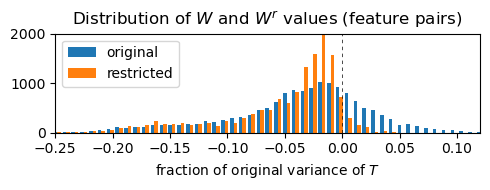

In [18]:
plt.figure(figsize=(5, 2))
plt.hist([W_values, WR_values], bins=80, label=['original', 'restricted']);
plt.title('Distribution of $W$ and $W^r$ values (feature pairs)')
plt.xlabel('fraction of original variance of $T$')
plt.axvline(x = 0, color = 'k', lw=0.5, linestyle=(0,(5,5)))
plt.legend(loc="upper left");
plt.xlim(-0.25, 0.12)
plt.ylim(0, 2000)
plt.tight_layout()
plt.savefig('output/w_w_dist.pdf')
plt.savefig('output/w_w_dist.png')

In [19]:
def distortColorMap(cm,inv = lambda x:x):
    """Inspired from 'make_colormap' in Serenity's answer.

    Inputs : a pre-existing colormap cm, 
             the distorsion function inv

    Output : the distorted colormap"""

    def f(color,inv):
        """In the sequence definition, modifies the position of stops tup[0] according the transformation function.

           Returns the distorted sequence."""
        return map(lambda tup:(inv(tup[0]),tup[1],tup[2]),color)

    # Extract sequences from cm, apply inv
    C = cm.__dict__['_segmentdata']
    cdict = {'red': f(C['red']  ,inv), 'green': f(C['green'],inv), 'blue': f(C['blue'] ,inv)}

    name = 'new_'+cm.__dict__['name']
    return colors.LinearSegmentedColormap(name, cdict)

In [20]:
#modified nonlinear colormap to emphasize positive values
class ModifiedCmap(matplotlib.colors.ListedColormap):
     def __call__(self, X, alpha=None, bytes=False):
            Xzc = X-0.5
            Xzc2 = Xzc + (Xzc>=0)*Xzc**2
            X2 = np.minimum(Xzc2 + 0.5, 1)
            return super().__call__(X2, alpha, bytes)
modifiedViridis = ModifiedCmap(plt.cm.viridis.__dict__['colors'], name="viridis2")

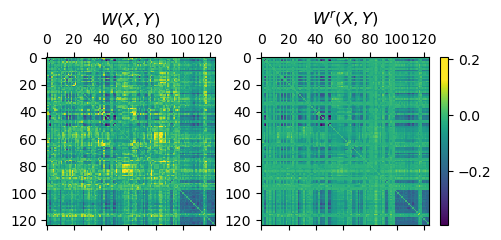

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(5, 2.5))
ax1, ax2 = axes

im1 = ax1.matshow(W_XY/evaluator.base_mse, cmap=modifiedViridis)
ax1.set_title('$W(X,Y)$')
im2 = ax2.matshow(WR_XY/evaluator.base_mse, cmap=modifiedViridis, vmin=W_XY.min()/evaluator.base_mse, vmax=W_XY.max()/evaluator.base_mse)
ax2.set_title('$W^r(X,Y)$')
plt.subplots_adjust(hspace=0, wspace=0, left=0, right=1)
fig.colorbar(im1, ax=ax2);
plt.tight_layout()
plt.savefig('output/w_w_heatmap.pdf')
plt.savefig('output/w_w_heatmap.png')

In [22]:
MSE_diff = (evaluator.get_feature_matrix(cols, col2_mse_er) - evaluator.get_feature_matrix(cols, col2_mse_e))/evaluator.base_mse

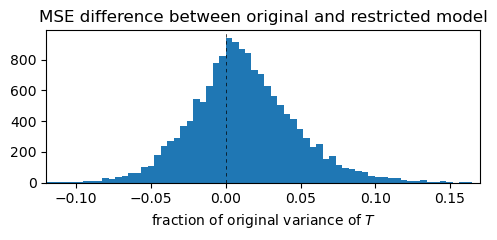

In [23]:
plt.figure(figsize=(5, 2.5))
plt.title('MSE difference between original and restricted model')
plt.hist(MSE_diff.reshape(-1), bins=100);
plt.axvline(x = 0, color = 'k', lw=0.5, linestyle=(0,(5,5)))
plt.xlabel('fraction of original variance of $T$')
plt.tight_layout()
plt.xlim(-0.12, 0.17)
plt.savefig('output/mse_diff.pdf')
plt.savefig('output/mse_diff.png')

# Demonstrative example

In [24]:
c1 = "population"
c2 = "NumKidsBornNeverMar"

## correlation

In [25]:
reader.train[c1].corr(reader.train[c2])

0.9683111627153071

# contributions

In [26]:
# utility to get mse from dictionary regardless of column order
def mse(mse_dict, col1, col2):
    return mse_dict[(col1, col2)] if (col1, col2) in mse_dict else mse_dict[(col2, col1)]

In [27]:
mse_reduction_c1 = col_mse[c1]-evaluator.base_mse
mse_reduction_c2 = col_mse[c2]-evaluator.base_mse
mse_reduction_both_e = mse(col2_mse_e, c1, c2)-evaluator.base_mse
mse_reduction_both_er = mse(col2_mse_er, c1, c2)-evaluator.base_mse

pd.DataFrame([
    ("MSE Reduction % with $E$", mse_reduction_c1, mse_reduction_c2, mse_reduction_both_e), 
    ("MSE Reduction % with $E^r$", mse_reduction_c1, mse_reduction_c2, mse_reduction_both_er),
    ("Contribution with $E$", mse_reduction_c1, mse_reduction_both_e-mse_reduction_c1, None),
    ("Contribution with $E^r$", mse_reduction_c1, mse_reduction_both_er-mse_reduction_c1, None)
], columns=['column_name', c1, c2, "both"]).set_index('column_name') / evaluator.base_mse

,population,NumKidsBornNeverMar,both
column_name,,,
MSE Reduction % with $E$,-0.141754,-0.365112,-0.511186
MSE Reduction % with $E^r$,-0.141754,-0.365112,-0.365112
Contribution with $E$,-0.141754,-0.369432,NaN
Contribution with $E^r$,-0.141754,-0.223358,NaN


## contributions when included after 'PctFam2Par'

In [28]:
pre_included_col = 'PctFam2Par'
trainData = utils.TrainingData(reader, target, columns=[pre_included_col, c1, c2])

booster = trainer.train_model(trainData)
new_mse_e = evaluator.get_model_mse(booster)

booster = trainer.train_model(trainData, override_params={
    'interaction_constraints': [[0],[1],[2]],
})
new_mse_er = evaluator.get_model_mse(booster)

new_base_mse = col_mse[pre_included_col]

#### contribution of 'PctFam2Par'

In [29]:
(new_base_mse-evaluator.base_mse)/evaluator.base_mse

-0.3724451492988417

#### contributions

In [30]:
mse_reduction_c1_e = mse(col2_mse_e, pre_included_col, c1)-new_base_mse
mse_reduction_c2_e = mse(col2_mse_e, pre_included_col, c2)-new_base_mse
mse_reduction_c1_er = mse(col2_mse_er, pre_included_col, c1)-new_base_mse
mse_reduction_c2_er = mse(col2_mse_er, pre_included_col, c2)-new_base_mse
mse_reduction_both_e = new_mse_e-new_base_mse
mse_reduction_both_er = new_mse_er-new_base_mse

pd.DataFrame([
    ("MSE Reduction % with $E$", mse_reduction_c1_e, mse_reduction_c2_e, mse_reduction_both_e), 
    ("MSE Reduction % with $E^r$", mse_reduction_c1_er, mse_reduction_c2_er, mse_reduction_both_er),
    ("Contribution with $E$", mse_reduction_c1_e, mse_reduction_both_e-mse_reduction_c1_e, None),
    ("Contribution with $E^r$", mse_reduction_c1_er, mse_reduction_c1_er-mse_reduction_both_er, None)
], columns=['column_name', c1, c2, "both"]).set_index('column_name') / evaluator.base_mse

,population,NumKidsBornNeverMar,both
column_name,,,
MSE Reduction % with $E$,-0.052381,-0.094069,-0.091657
MSE Reduction % with $E^r$,-0.029524,-0.066301,-0.066301
Contribution with $E$,-0.052381,-0.039276,NaN
Contribution with $E^r$,-0.029524,0.036777,NaN


In [31]:
trainData = utils.TrainingData(reader, target, columns=[c1, c2])

booster = trainer.train_model(trainData)
booster2 = trainer.train_model(trainData, override_params={
    'interaction_constraints': [[0],[1]],
})

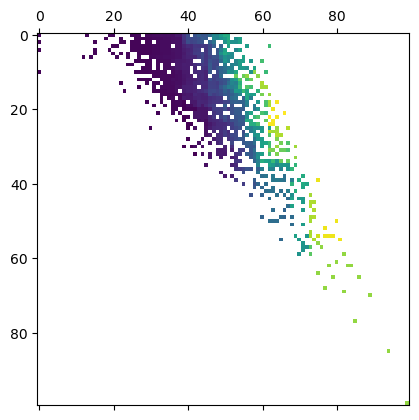

In [32]:
xyz = trainData.train.data.copy()
xyz['pred'] = booster.predict(xyz)
plt.matshow(stats.binned_statistic_2d(np.log(xyz[c1]), np.log(xyz[c2]+1), xyz['pred'], statistic='mean', bins=100)[0])

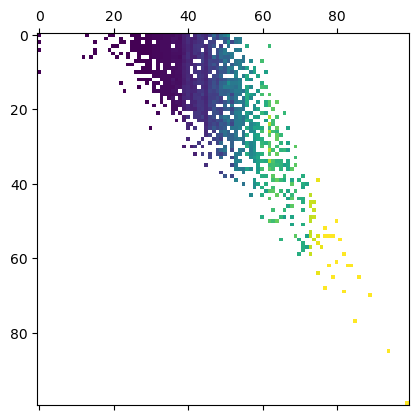

In [33]:
xyz = trainData.train.data.copy()
xyz['pred'] = booster2.predict(xyz)
plt.matshow(stats.binned_statistic_2d(np.log(xyz[c1]), np.log(xyz[c2]+1), xyz['pred'], statistic='mean', bins=100)[0])

# Demonstrative example 2

In [34]:
c1 = "agePct12t29"
c2 = "MalePctNevMarr"

## correlation

In [35]:
reader.train[c1].corr(reader.train[c2])

0.7919304071478618

# contributions

In [36]:
# utility to get mse from dictionary regardless of column order
def mse(mse_dict, col1, col2):
    return mse_dict[(col1, col2)] if (col1, col2) in mse_dict else mse_dict[(col2, col1)]

In [37]:
mse_reduction_c1 = col_mse[c1]-evaluator.base_mse
mse_reduction_c2 = col_mse[c2]-evaluator.base_mse
mse_reduction_both_e = mse(col2_mse_e, c1, c2)-evaluator.base_mse
mse_reduction_both_er = mse(col2_mse_er, c1, c2)-evaluator.base_mse

pd.DataFrame([
    ("MSE Reduction % with $E$", mse_reduction_c1, mse_reduction_c2, mse_reduction_both_e), 
    ("MSE Reduction % with $E^r$", mse_reduction_c1, mse_reduction_c2, mse_reduction_both_er),
    ("Contribution with $E$", mse_reduction_c1, mse_reduction_both_e-mse_reduction_c1, None),
    ("Contribution with $E^r$", mse_reduction_c1, mse_reduction_both_er-mse_reduction_c1, None)
], columns=['column_name', c1, c2, "both"]).set_index('column_name') / evaluator.base_mse

,agePct12t29,MalePctNevMarr,both
column_name,,,
MSE Reduction % with $E$,-0.075779,-0.092226,-0.227035
MSE Reduction % with $E^r$,-0.075779,-0.092226,-0.108310
Contribution with $E$,-0.075779,-0.151256,NaN
Contribution with $E^r$,-0.075779,-0.032530,NaN


## contributions when included after 'PctFam2Par'

In [38]:
pre_included_col = 'PctFam2Par'
trainData = utils.TrainingData(reader, target, columns=[pre_included_col, c1, c2])

booster = trainer.train_model(trainData)
new_mse_e = evaluator.get_model_mse(booster)

booster = trainer.train_model(trainData, override_params={
    'interaction_constraints': [[0],[1],[2]],
})
new_mse_er = evaluator.get_model_mse(booster)

new_base_mse = col_mse[pre_included_col]

#### contribution of 'PctFam2Par'

In [39]:
(new_base_mse-evaluator.base_mse)/evaluator.base_mse

-0.3724451492988417

#### contributions

In [40]:
mse_reduction_c1_e = mse(col2_mse_e, pre_included_col, c1)-new_base_mse
mse_reduction_c2_e = mse(col2_mse_e, pre_included_col, c2)-new_base_mse
mse_reduction_c1_er = mse(col2_mse_er, pre_included_col, c1)-new_base_mse
mse_reduction_c2_er = mse(col2_mse_er, pre_included_col, c2)-new_base_mse
mse_reduction_both_e = new_mse_e-new_base_mse
mse_reduction_both_er = new_mse_er-new_base_mse

pd.DataFrame([
    ("MSE Reduction % with $E$", mse_reduction_c1_e, mse_reduction_c2_e, mse_reduction_both_e), 
    ("MSE Reduction % with $E^r$", mse_reduction_c1_er, mse_reduction_c2_er, mse_reduction_both_er),
    ("Contribution with $E$", mse_reduction_c1_e, mse_reduction_both_e-mse_reduction_c1_e, None),
    ("Contribution with $E^r$", mse_reduction_c1_er, mse_reduction_c1_er-mse_reduction_both_er, None)
], columns=['column_name', c1, c2, "both"]).set_index('column_name') / evaluator.base_mse

,agePct12t29,MalePctNevMarr,both
column_name,,,
MSE Reduction % with $E$,-0.00231,0.017199,-0.012516
MSE Reduction % with $E^r$,0.00000,0.000000,0.000000
Contribution with $E$,-0.00231,-0.010206,NaN
Contribution with $E^r$,0.00000,0.000000,NaN


In [41]:
trainData = utils.TrainingData(reader, target, columns=[c1, c2])

booster = trainer.train_model(trainData)
booster2 = trainer.train_model(trainData, override_params={
    'interaction_constraints': [[0],[1]],
})

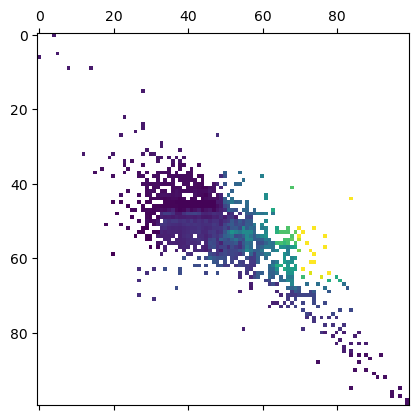

In [42]:
xyz = trainData.train.data.copy()
xyz['pred'] = booster.predict(xyz)
plt.matshow(stats.binned_statistic_2d(np.log(xyz[c1]), np.log(xyz[c2]+1), xyz['pred'], statistic='mean', bins=100)[0])

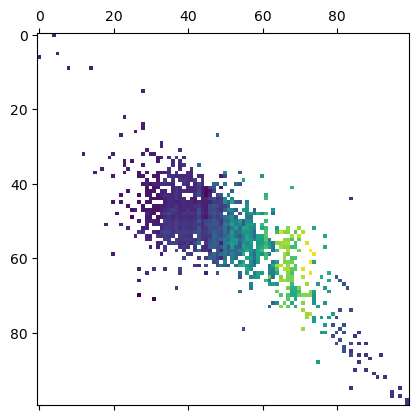

In [43]:
xyz = trainData.train.data.copy()
xyz['pred'] = booster2.predict(xyz)
plt.matshow(stats.binned_statistic_2d(np.log(xyz[c1]), np.log(xyz[c2]+1), xyz['pred'], statistic='mean', bins=100)[0])